In [4]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

import pandas as pd

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [ ]:
data = pd.read_csv("btc_data.csv",delimiter=";")

In [3]:
data.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,circulatingSupply,timestamp
0,2025-10-21T00:00:00.000Z,2025-10-21T23:59:59.999Z,2025-10-21T16:37:00.000Z,2025-10-21T08:48:00.000Z,2781,110587.629936,113996.346348,107534.749138,108476.886979,1.011944e+11,2.163102e+12,19937981,2025-10-21T23:59:59.999Z
1,2025-10-20T00:00:00.000Z,2025-10-20T23:59:59.999Z,2025-10-20T15:53:00.000Z,2025-10-20T00:34:00.000Z,2781,108667.443809,111711.033248,107485.014270,110588.930159,6.350779e+10,2.204869e+12,19937518,2025-10-20T23:59:59.999Z
2,2025-10-19T00:00:00.000Z,2025-10-19T23:59:59.999Z,2025-10-19T18:58:00.000Z,2025-10-19T09:30:00.000Z,2781,107204.314120,109488.992543,106157.790609,108666.711526,4.765701e+10,2.166469e+12,19936690,2025-10-19T23:59:59.999Z
3,2025-10-18T00:00:00.000Z,2025-10-18T23:59:59.999Z,2025-10-18T07:13:00.000Z,2025-10-18T00:17:00.000Z,2781,106483.735232,107490.981181,106387.449935,107198.266851,3.777991e+10,2.137289e+12,19936593,2025-10-18T23:59:59.999Z
4,2025-10-17T00:00:00.000Z,2025-10-17T23:59:59.999Z,2025-10-17T04:03:00.000Z,2025-10-17T10:25:00.000Z,2781,108179.134712,109235.807656,103598.428851,106467.785228,9.970305e+10,2.122870e+12,19936096,2025-10-17T23:59:59.999Z


In [7]:
# if your file is tab-separated:
df = pd.read_csv(
    "btc_data.csv",
    sep=";",  # or delim_whitespace=True, or sep="," if comma-separated
    parse_dates=[
        "timeOpen", "timeClose", "timeHigh", "timeLow", "timestamp"
    ],
)
# sort chronologically
df = df.sort_values("timestamp").reset_index(drop=True)

# pick the feature columns and the target column
features = df[["open", "high", "low", "close", "volume"]].values.astype(np.float32)
timestamps = df["timestamp"].values

In [24]:
from sklearn.preprocessing import MinMaxScaler
# scale each feature to [0,1]
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

# train/test split (80/20), but keep seq_len overlap for test
seq_len = 4
N = len(features_norm)
train_end = int(N * 0.8)

train_data = features_norm[:train_end]
# we start the test series seq_len points before the split so we can build sequences
test_data = features_norm[train_end - seq_len :]
test_timestamps = timestamps[train_end:]

In [25]:
from torch.utils.data import Dataset, DataLoader
class SequenceDataset(Dataset):
    def __init__(self, data: np.ndarray, seq_len: int):
        """
        data: (T, n_features) array
        seq_len: length of input sequence
        """
        self.X = []
        self.y = []
        for i in range(len(data) - seq_len):
            seq = data[i : i + seq_len]
            target_close = data[i + seq_len, 3]  # index 3 == 'close'
            self.X.append(seq)
            self.y.append(target_close)
        self.X = np.stack(self.X)            # (samples, seq_len, n_features)
        self.y = np.array(self.y, dtype=np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # return torch tensors
        return (
            torch.from_numpy(self.X[idx]),     # (seq_len, n_features)
            torch.from_numpy(self.y[idx])      # (1,)
        )

# make datasets
train_ds = SequenceDataset(train_data, seq_len)
test_ds  = SequenceDataset(test_data, seq_len)

# dataloaders
batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))

Train batches: 40 Test batches: 10


In [26]:
# grab one batch
xb, yb = next(iter(train_loader))
print("xb shape:", xb.shape, "yb shape:", yb.shape)

# move to device
xb, yb = xb.to(device), yb.to(device)
print("xb device:", xb.device, "yb device:", yb.device)

# xb dims: (batch_size, seq_len, n_features)
# yb dims: (batch_size, 1)

xb shape: torch.Size([8, 4, 5]) yb shape: torch.Size([8, 1])
xb device: cuda:0 yb device: cuda:0


In [33]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(
        self,
        n_features: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, seq_len, n_features)
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # (B, hidden_size)
        return self.fc(last)         # (B, 1)

In [49]:
import torch

# hyperparams
n_features = 5            # open, high, low, close, volume
hidden_size = 64
num_layers = 2
dropout = 0.2
lr = 1e-3
epochs = 20

# model / optimizer / loss
model = LSTMModel(n_features, hidden_size, num_layers, dropout).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs + 1):
    model.train()
    running = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optim.step()
        running.append(loss.item())
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs}  loss={sum(running)/len(running):.6f}")

Epoch 01/20  loss=0.053807
Epoch 05/20  loss=0.005278
Epoch 10/20  loss=0.003917
Epoch 15/20  loss=0.005243
Epoch 20/20  loss=0.021362


Directional accuracy: 58.75%


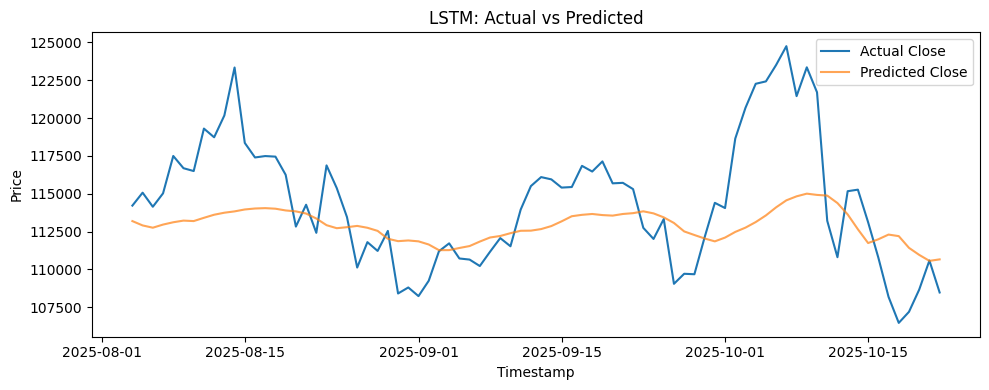

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1) Gather predictions + truths

model.eval()
preds_norm, trues_norm = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().flatten()
        preds_norm.extend(out.tolist())
        trues_norm.extend(yb.numpy().flatten().tolist())

# 2) Invert scaling only for the 'close' feature (index 3)
min_c, max_c = scaler.data_min_[3], scaler.data_max_[3]
preds_raw = np.array(preds_norm) * (max_c - min_c) + min_c
trues_raw = np.array(trues_norm) * (max_c - min_c) + min_c

# 3) Compute prev-bar raw close for direction check
close_raw = df["close"].values
prev_raw = close_raw[train_end - 1 : len(close_raw) - 1]

# 4) Directional accuracy
actual_dir = (trues_raw > prev_raw).astype(int)
pred_dir   = (preds_raw > prev_raw).astype(int)
acc = accuracy_score(actual_dir, pred_dir) * 100
print(f"Directional accuracy: {acc:.2f}%")

# 5) Plot
ts_test = test_timestamps  
plt.figure(figsize=(10, 4))
plt.plot(ts_test, trues_raw, label="Actual Close")
plt.plot(ts_test, preds_raw, alpha=0.7, label="Predicted Close")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# assume `df` is your original DataFrame sorted by timestamp
import numpy as np

# copy only needed cols
df_feat = df[['timestamp','open','high','low','close','volume']].copy()

# 1-period return
df_feat['ret1'] = (df_feat['close'] - df_feat['open']) / df_feat['open']

# volume change vs prior bar
df_feat['vol_chg'] = df_feat['volume'] / df_feat['volume'].shift(1) - 1

# 5-bar rolling mean & std of close
df_feat['ma5_close'] = df_feat['close'].rolling(5).mean()
df_feat['std5_close'] = df_feat['close'].rolling(5).std()

# next-bar close as target
df_feat['next_close'] = df_feat['close'].shift(-1)

# drop any rows with NaNs
df_feat = df_feat.dropna().reset_index(drop=True)

In [56]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# feature cols
features = ['ret1','vol_chg','ma5_close','std5_close']

# 80/20 split
split_idx = int(len(df_feat) * 0.8)
train_df = df_feat.iloc[:split_idx]
test_df  = df_feat.iloc[split_idx:]

X_train, y_train = train_df[features], train_df['next_close']
X_test,  y_test  = test_df[features],  test_df['next_close']

# init AdaBoost with shallow trees
abr = AdaBoostRegressor(
    n_estimators=2000,
    random_state=10
)

# fit & predict
abr.fit(X_train, y_train)
preds = abr.predict(X_test)

# metrics
mse     = mean_squared_error(y_test, preds)
dir_acc = accuracy_score(
    (y_test > test_df['close']).astype(int),
    (preds >  test_df['close']).astype(int)
) * 100

print(f"AdaBoostRegressor MSE: {mse:.2f}")
print(f"AdaBoostRegressor Directional Accuracy: {dir_acc:.2f}%")

AdaBoostRegressor MSE: 14263914.94
AdaBoostRegressor Directional Accuracy: 54.43%


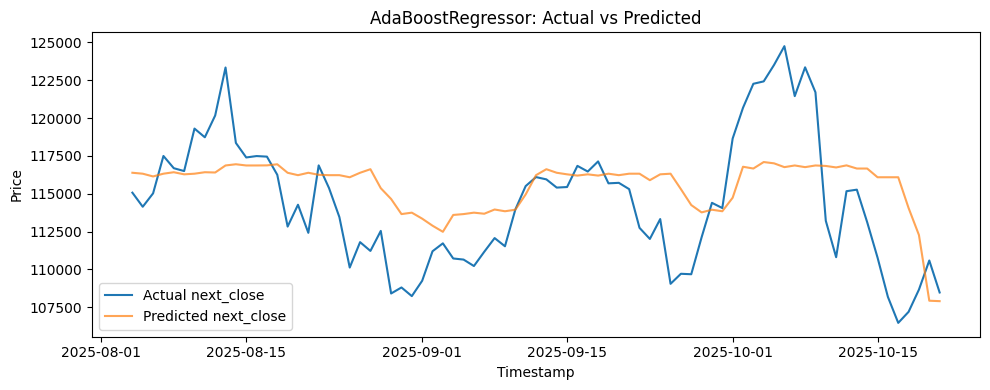

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(test_df['timestamp'], y_test, label='Actual next_close')
plt.plot(test_df['timestamp'], preds, alpha=0.7, label='Predicted next_close')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('AdaBoostRegressor: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

RandomForestRegressor MSE: 15014913.02
RandomForestRegressor Directional Accuracy: 50.63%


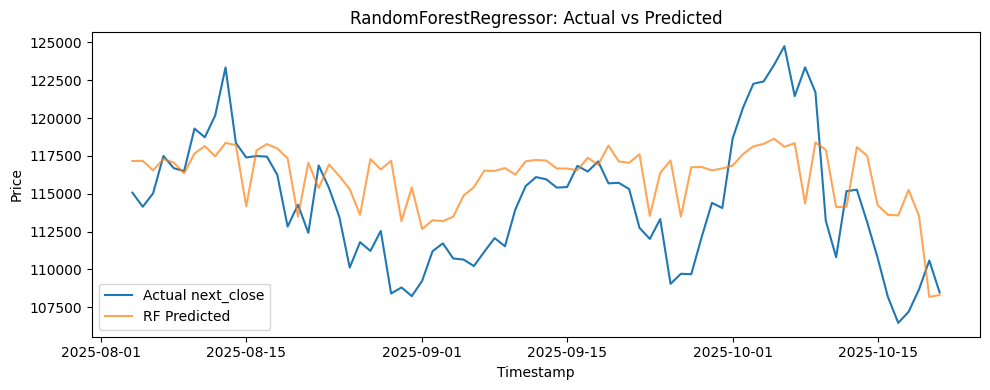